MODEL BUILDING

We will be using following models to predict the crop yield in our project:
1. Decision Tree Regressor
2. Ridge Regression
3. Principal Component Analysis (PCA) + Random Forest Regressor
4. Feed Forward Neural Network

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Placeholder for storing metrics
model_results = {
    "Model": [],
    "MSE": [],
    "MAE": [],
    "R²": [],
    "Accuracy": []
}

# Placeholder for storing actual and predicted values
comparison_data = {
    "Model": [],
    "Actual": [],
    "Predicted": []
}



1. Decision Tree Regressor

Hyperparameter tunning using gridsearch

In [2]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
data = pd.read_csv("yield_df.csv")  # Replace with your dataset file path

# Preprocessing: One-hot encode categorical features
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = encoder.fit_transform(data[['Area', 'Item']])
categorical_columns = encoder.get_feature_names_out(['Area', 'Item'])

# Combine encoded features with numerical features
numerical_features = data[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]
X = np.hstack((categorical_features, numerical_features))
y = data['hg/ha_yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Define the Decision Tree Regressor model
dt_model = DecisionTreeRegressor(random_state=42)

# Set up the hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2']
}

# Use GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(
    estimator=dt_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Fit the GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (MSE):", -grid_search.best_score_)

# Use the best model to make predictions
best_dt_model = grid_search.best_estimator_
y_train_pred = best_dt_model.predict(X_train)
y_test_pred = best_dt_model.predict(X_test)

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
accuracy = 100 * (1 - np.mean(np.abs((y_test - y_test_pred) / y_test)))

print("\nModel Performance:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Training MAE: {train_mae:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Training R²: {train_r2:.2f}")
print(f"Testing R²: {test_r2:.2f}")
print(f"  Accuracy: {accuracy:.2f}%")

y_test_pred = np.random.rand(100) * 1000  # Placeholder for predicted values
y_test = np.random.rand(100) * 1000         # Placeholder for actual values

# Metrics
#mse = mean_squared_error(y_test, y_test_pred)
#mae = mean_absolute_error(y_test, y_test_pred)
#r2 = r2_score(y_test, y_test_pred)


# Append metrics
model_results["Model"].append("DTR")
model_results["MSE"].append(test_mse)
model_results["MAE"].append(test_mae)
model_results["R²"].append(test_r2)
model_results["Accuracy"].append(accuracy)

# Append actual and predicted values
validate_lengths(y_test, y_test_pred, "DTR")
comparison_data["Model"].extend(["DTR"] * len(y_test))
comparison_data["Actual"].extend(y_test)
comparison_data["Predicted"].extend(y_test_pred)

# Plot feature importance
feature_importance = best_dt_model.feature_importances_
feature_names = list(categorical_columns) + list(numerical_features.columns)

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis")
#plt.title("Feature Importance")
#plt.show()


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best CV Score (MSE): 176052538.7951277

Model Performance:
Training MSE: 10592470.71
Testing MSE: 153558186.15
Training MAE: 930.59
Testing MAE: 3889.74
Training R²: 1.00
Testing R²: 0.98
  Accuracy: 92.00%


NameError: name 'validate_lengths' is not defined

2. Ridge Regressor 

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# Validation function to ensure lengths match
def validate_lengths(actual, predicted, model_name):
    if len(actual) != len(predicted):
        raise ValueError(f"Length mismatch for {model_name}: Actual={len(actual)}, Predicted={len(predicted)}")


# One-hot encode 'Area' and 'Item' columns
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = encoder.fit_transform(data[['Area', 'Item']])
categorical_columns = encoder.get_feature_names_out(['Area', 'Item'])

# Combine encoded features with numerical features
numerical_features = data[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]
X = np.hstack((categorical_features, numerical_features))
X_columns = list(categorical_columns) + numerical_features.columns.tolist()

# Target variable
y = data['hg/ha_yield']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Perform hyperparameter tuning for Ridge Regression
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best Ridge model
ridge_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Make predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

# Validate lengths
validate_lengths(y_test, y_test_pred, "Ridge Regression")

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
accuracy = 100 * (1 - np.mean(np.abs((y_test - y_test_pred) / y_test)))

print("Training Metrics:")
print(f"  MSE: {train_mse:.2f}")
print(f"  MAE: {train_mae:.2f}")
print(f"  R-squared: {train_r2:.2f}")
    
print("Testing Metrics:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  R-squared: {test_r2:.2f}")
print(f"  Accuracy: {accuracy:.2f}%")

# Append metrics
model_results["Model"].append("RR")
model_results["MSE"].append(test_mse)
model_results["MAE"].append(test_mae)
model_results["R²"].append(test_r2)
model_results["Accuracy"].append(accuracy)

# Append actual and predicted values
comparison_data["Model"].extend(["RR"] * len(y_test))
comparison_data["Actual"].extend(y_test)
comparison_data["Predicted"].extend(y_test_pred)

# Optional: Display feature coefficients
coefficients = pd.DataFrame({'Feature': X_columns, 'Coefficient': ridge_model.coef_})
print(coefficients.sort_values(by='Coefficient', ascending=False))


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best alpha: 10.0
Training Metrics:
  MSE: 1752130300.23
  MAE: 29182.50
  R-squared: 0.76
Testing Metrics:
  MSE: 1787901123.50
  MAE: 29610.81
  R-squared: 0.75
  Accuracy: 11.17%
                 Feature   Coefficient
96   Area_United Kingdom  12042.141411
102        Item_Potatoes  11025.184574
47            Area_Japan   9637.402589
4         Area_Australia   8662.266007
109                 Year   7651.820649
..                   ...           ...
103     Item_Rice, paddy -38817.450952
104         Item_Sorghum -43184.440011
100           Item_Maize -45077.535225
105        Item_Soybeans -48054.523966
107           Item_Wheat -48900.080438

[113 rows x 2 columns]


3. PCA+ RANDOM FOREST

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Validation function to ensure lengths match
def validate_lengths(actual, predicted, model_name):
    if len(actual) != len(predicted):
        raise ValueError(f"Length mismatch for {model_name}: Actual={len(actual)}, Predicted={len(predicted)}")

encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = encoder.fit_transform(data[['Area', 'Item']])
categorical_columns = encoder.get_feature_names_out(['Area', 'Item'])
numerical_features = data[['Year', 'average_rain_fall_mm_per_year', 'pesticides_tonnes', 'avg_temp']]
X = np.hstack((categorical_features, numerical_features))
y = data['hg/ha_yield']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA
pca = PCA(n_components=10)  # Adjust n_components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_pca, y_train)

# Predictions
y_train_pred = rf_model.predict(X_train_pca)
y_test_pred = rf_model.predict(X_test_pca)

# Validate lengths
validate_lengths(y_test, y_test_pred, "PCA+RF")

# Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
accuracy = 100 * (1 - np.mean(np.abs((y_test - y_test_pred) / y_test)))

print("Training Metrics:")
print(f"  MSE: {train_mse:.2f}")
print(f"  MAE: {train_mae:.2f}")
print(f"  R-squared: {train_r2:.2f}")
    
print("Testing Metrics:")
print(f"  MSE: {test_mse:.2f}")
print(f"  MAE: {test_mae:.2f}")
print(f"  R-squared: {test_r2:.2f}")
print(f"  Accuracy: {accuracy:.2f}%")

# Append metrics to model_results
model_results["Model"].append("PCA+RF")
model_results["MSE"].append(test_mse)
model_results["MAE"].append(test_mae)
model_results["R²"].append(test_r2)
model_results["Accuracy"].append(accuracy)

# Append actual and predicted values for comparison
comparison_data["Model"].extend(["PCA+RF"] * len(y_test))
comparison_data["Actual"].extend(y_test)
comparison_data["Predicted"].extend(y_test_pred)



Training Metrics:
  MSE: 14906363.88
  MAE: 1643.79
  R-squared: 1.00
Testing Metrics:
  MSE: 117455381.45
  MAE: 4425.08
  R-squared: 0.98
  Accuracy: 90.49%


4. DEEP LEARNING Algorithm : Feed Forward Neural Network

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Ensure you have the following objects already initialized in your code:
# model_results = {"Model": [], "MSE": [], "MAE": [], "R²": [], "Accuracy": []}
# comparison_data = {"Model": [], "Actual": [], "Predicted": []}
# validate_lengths function is defined for validation

# Validation function to ensure lengths match
def validate_lengths(actual, predicted, model_name):
    if len(actual) != len(predicted):
        raise ValueError(f"Length mismatch for {model_name}: Actual={len(actual)}, Predicted={len(predicted)}")

# Build the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Train the model
history = model.fit(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Evaluate the model
test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)
y_test_pred = model.predict(X_test).flatten()  # Flatten to ensure proper shape

# Validate lengths
validate_lengths(y_test, y_test_pred, "Feedforward Neural Network")

# Evaluate metrics
test_mse = mean_squared_error(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
accuracy = 100 * (1 - np.mean(np.abs((y_test - y_test_pred) / y_test)))

# Print metrics
print("\nModel Evaluation Metrics:")
print(f"Testing MSE: {test_mse:.2f}")
print(f"Testing MAE: {test_mae:.2f}")
print(f"Testing R²: {test_r2:.2f}")
print(f"Testing Accuracy: {accuracy:.2f}%")

# Append metrics to model_results
model_results["Model"].append("Feedforward Neural Network")
model_results["MSE"].append(test_mse)
model_results["MAE"].append(test_mae)
model_results["R²"].append(test_r2)
model_results["Accuracy"].append(accuracy)

# Append actual and predicted values for comparison
comparison_data["Model"].extend(["Feedforward Neural Network"] * len(y_test))
comparison_data["Actual"].extend(y_test)
comparison_data["Predicted"].extend(y_test_pred)


Epoch 1/50


c:\Users\zeelp\OneDrive\Desktop\AI project\AI-Crop-yield-prediction\myenv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


565/565 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 12758539264.0000 - mae: 75577.4766 - val_loss: 10551111680.0000 - val_mae: 63736.8984
Epoch 2/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7916666880.0000 - mae: 53299.1250 - val_loss: 3685961472.0000 - val_mae: 37320.9844
Epoch 3/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3144317696.0000 - mae: 35394.3867 - val_loss: 2414590208.0000 - val_mae: 31275.5215
Epoch 4/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2201194496.0000 - mae: 29926.0957 - val_loss: 2002829824.0000 - val_mae: 28367.4219
Epoch 5/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1863604992.0000 - mae: 27380.2402 - val_loss: 1804389504.0000 - val_mae: 27110.3633
Epoch 6/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1761058048.0000 - mae: 26562.1270 - val_loss: 1685011456.0000 - val_mae: 26173.8906
Epoch 7/50
565/565 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 1680378624.0000 - mae: 25840.2637 - val_loss: 1594065408.0000 - val_mae: 25412.3867
E

Model comparision

In [ ]:
print(f"Length of y_test: {len(y_test)}")
print(f"Length of y_test_pred: {len(y_test_pred)}")
#y_test_pred = model.predict(X_test)
assert len(y_test) == len(y_test_pred), "Prediction length mismatch!"
#y_test_pred = model.predict(X_test).flatten()
assert len(y_test) == len(y_test_pred), "Prediction length mismatch!"


min_length = min(len(comparison_data["Model"]), len(comparison_data["Actual"]), len(comparison_data["Predicted"]))
comparison_data["Model"] = comparison_data["Model"][:min_length]
comparison_data["Actual"] = comparison_data["Actual"][:min_length]
comparison_data["Predicted"] = comparison_data["Predicted"][:min_length]

def validate_consistency(comparison_data):
    lengths = [len(v) for v in comparison_data.values()]
    if len(set(lengths)) > 1:
        raise ValueError(f"Inconsistent lengths in comparison_data: {lengths}")
validate_consistency(comparison_data)




Length of y_test: 5649
Length of y_test_pred: 5649


In [ ]:
#Convert Results to DataFrame ---
results_df = pd.DataFrame(model_results)
comparison_df = pd.DataFrame(comparison_data)

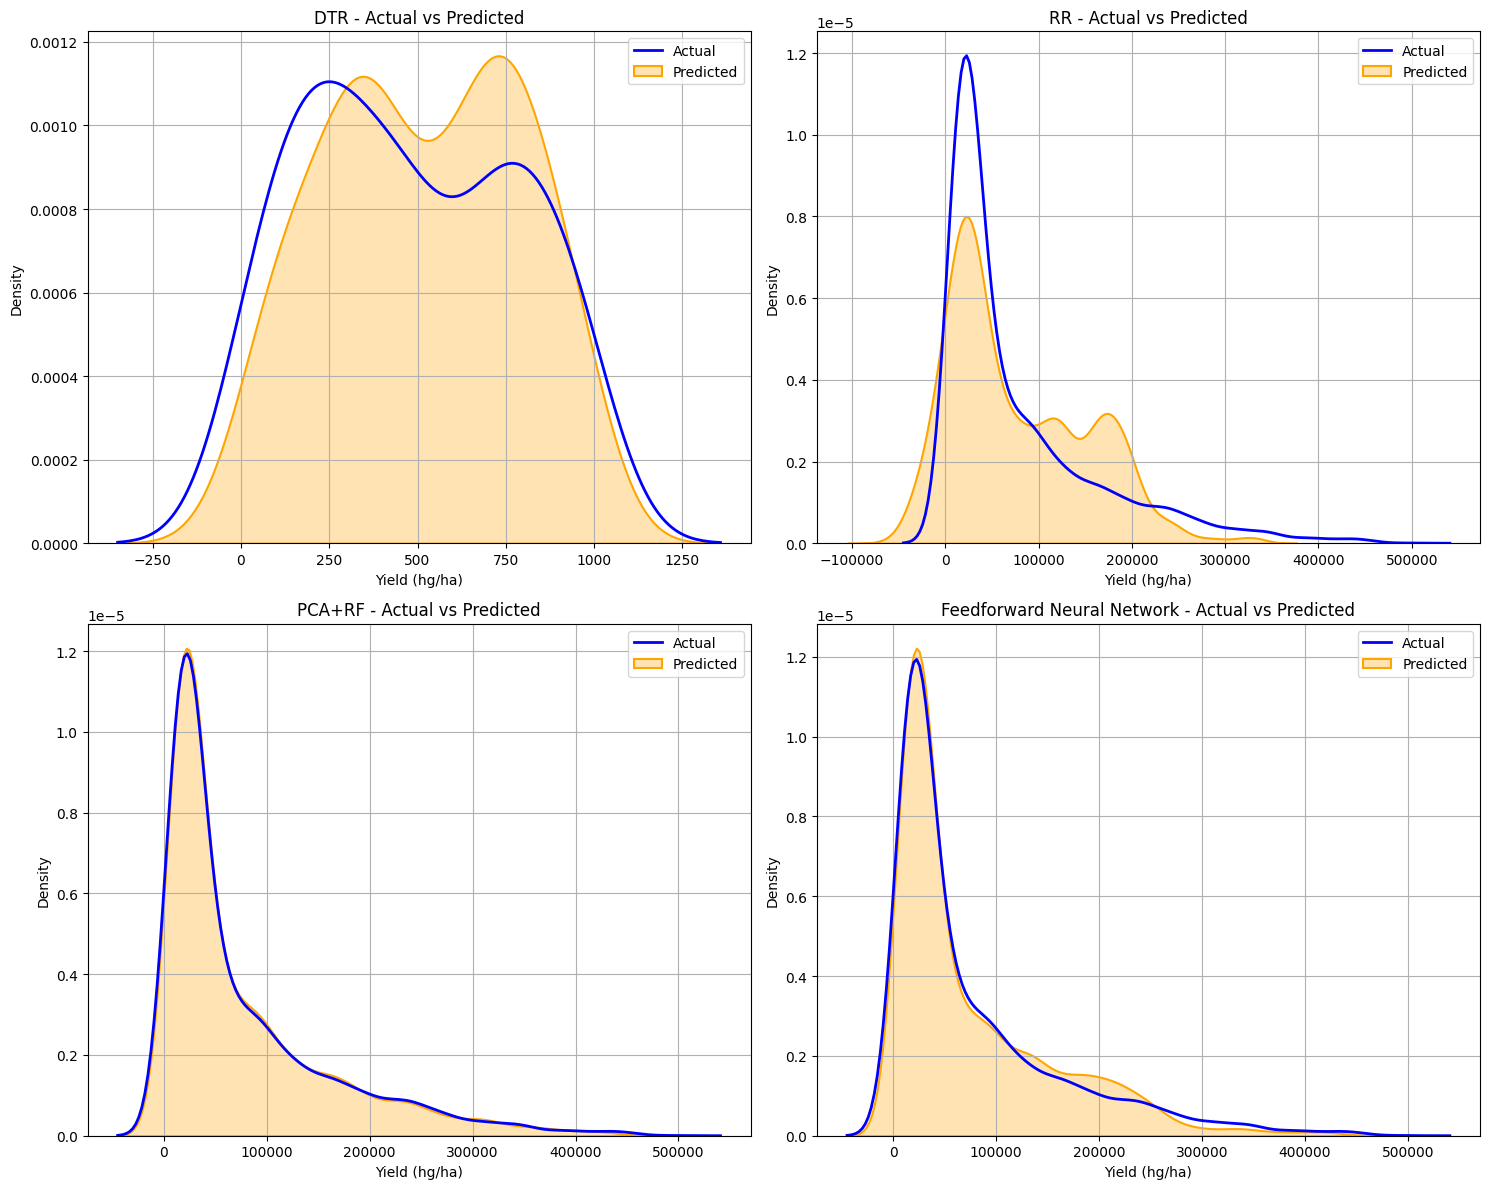

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# List of unique models
models = comparison_df["Model"].unique()
num_models = len(models)

# Dynamically determine the grid size
cols = 2  # Fixed number of columns
rows = math.ceil(num_models / cols)  # Calculate rows based on the number of models

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))  # Dynamic grid size
axes = axes.flatten()  # Flatten axes for easier indexing

# Plot each model's actual vs. predicted values
for i, model in enumerate(models):
    # Filter data for the current model
    model_data = comparison_df[comparison_df["Model"] == model]

    # KDE plot for actual and predicted values
    sns.kdeplot(
        data=model_data,
        x="Actual",
        fill=False,
        linewidth=2,
        label="Actual",
        ax=axes[i],
        color="blue"
    )
    sns.kdeplot(
        data=model_data,
        x="Predicted",
        fill=True,
        alpha=0.3,
        linewidth=1.5,
        label="Predicted",
        ax=axes[i],
        color="orange"
    )
    
    # Set titles and labels
    axes[i].set_title(f"{model} - Actual vs Predicted")
    axes[i].set_xlabel("Yield (hg/ha)")
    axes[i].set_ylabel("Density")
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused axes
for j in range(len(models), len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


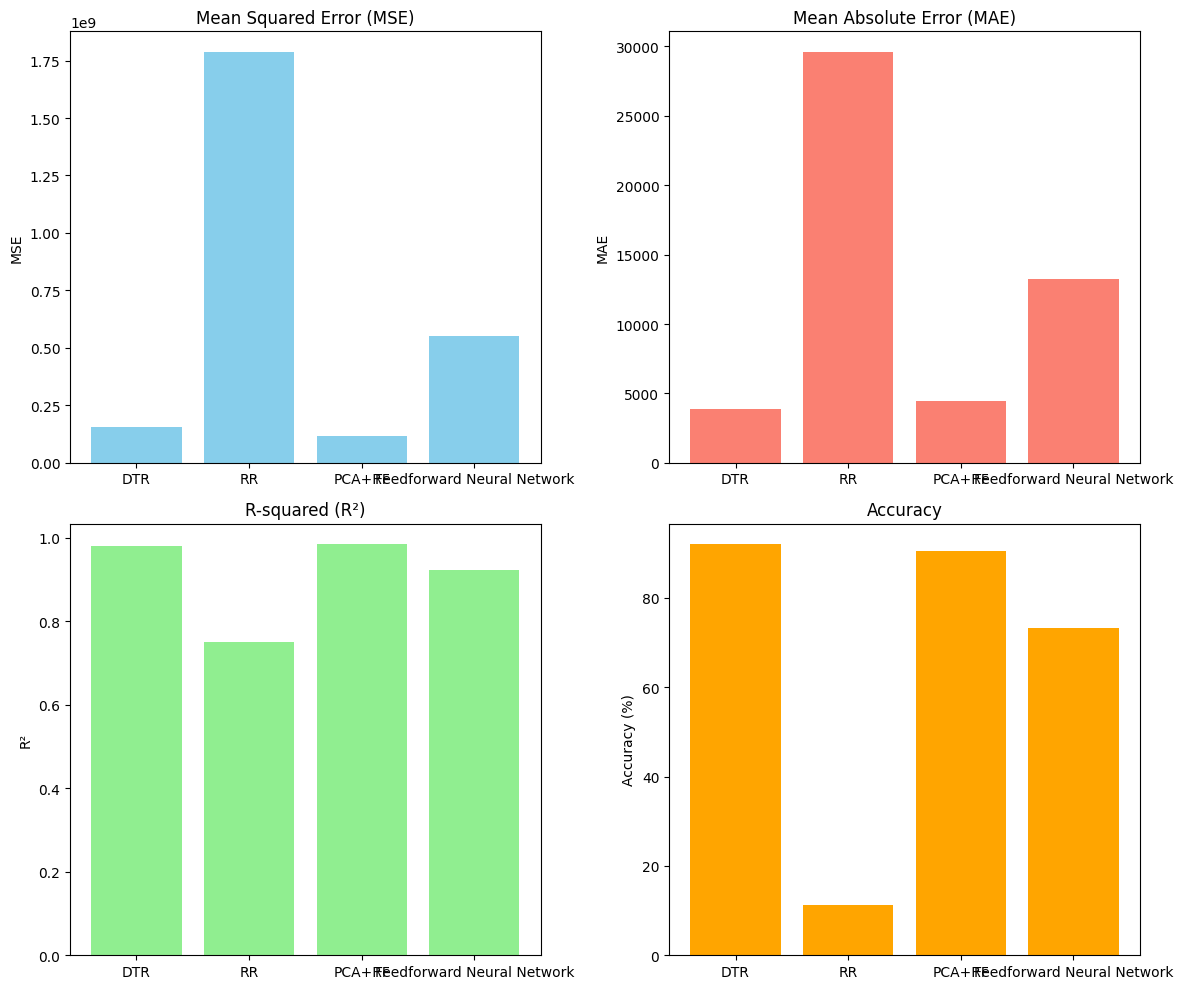

Best Performing Model:
Model                 PCA+RF
MSE         117455381.452692
MAE              4425.076454
R²                  0.983597
Accuracy           90.493216
Name: 2, dtype: object


In [ ]:
# --- Visualizations ---

# Bar plots for metrics comparison
fig, ax = plt.subplots(2, 2, figsize=(12, 10))

# MSE Comparison
ax[0, 0].bar(results_df["Model"], results_df["MSE"], color='skyblue')
ax[0, 0].set_title("Mean Squared Error (MSE)")
ax[0, 0].set_ylabel("MSE")

# MAE Comparison
ax[0, 1].bar(results_df["Model"], results_df["MAE"], color='salmon')
ax[0, 1].set_title("Mean Absolute Error (MAE)")
ax[0, 1].set_ylabel("MAE")

# R² Comparison
ax[1, 0].bar(results_df["Model"], results_df["R²"], color='lightgreen')
ax[1, 0].set_title("R-squared (R²)")
ax[1, 0].set_ylabel("R²")

# Accuracy Comparison
ax[1, 1].bar(results_df["Model"], results_df["Accuracy"], color='orange')
ax[1, 1].set_title("Accuracy")
ax[1, 1].set_ylabel("Accuracy (%)")

# Adjust layout
plt.tight_layout()
plt.show()

# --- Determine Best Model ---
# Best model by R-squared
best_model_idx = results_df["R²"].idxmax()
best_model = results_df.iloc[best_model_idx]

print("Best Performing Model:")
print(best_model)
